In [869]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
import librosa
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from torch.utils.data.dataset import random_split as split 
from sklearn.model_selection import train_test_split
import torch; from torch.utils.data import DataLoader, Dataset
import numpy as np 
import pandas as pd

print(torch.__version__)
print(torchaudio.__version__)
#torch.random.manual_seed(0)

MIN_SAMPLES = True
PATH_ANNOTATIONS = 'Wingbeats/min_annotations.txt' if MIN_SAMPLES else 'Wingbeats/annotations.txt'
n_classes = 6
lr = 1e-4
n_epochs = 50
batch_size = 32
SAMPLE_RATE = 8_000
nyquist_frequency = SAMPLE_RATE / 2
classes = ['An. gambiae', 'C. pipiens', 'C. quinquefasciatus', 'Ae. albopictus', 'An. arabiensis', 'Ae. aegypti']

2.8.0+cu128
2.8.0+cu128


In [870]:
def dividirDatos(archivoAnnotaciones, test_size=0.2, random_state=42):
    df = pd.read_csv(archivoAnnotaciones)
    train_df, test_df = train_test_split(
        df, 
        test_size=test_size,
        random_state=random_state,
        stratify=df['label']
    )
    print('Total = ', len(df))
    print('Total train = ', len(train_df))
    print('Total test = ', len(test_df))
    return train_df, test_df

In [871]:
class AudioDatasetFromTxt(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, index):
        audio_path = self.dataframe.iloc[index]['file_path']
        label = self.dataframe.iloc[index]['label']
        
        waveform, _ = librosa.load(audio_path, sr=SAMPLE_RATE)
        
        waveform = torch.from_numpy(waveform).float().unsqueeze(0)
        
        if self.transform:
            spectrogram = self.transform(waveform)
            return spectrogram, label
        else:
            return waveform, label

In [872]:
def plot_waveform(waveform, sr, title="Waveform", ax=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    ax.plot(time_axis, waveform[0], linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)


def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")


def plot_fbank(fbank, title=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Filter bank")
    axs.imshow(fbank, aspect="auto")
    axs.set_ylabel("frequency bin")
    axs.set_xlabel("mel bin")

In [873]:
train_df, test_df = dividirDatos(PATH_ANNOTATIONS)

Total =  115782
Total train =  92625
Total test =  23157


In [874]:
train_dataset = AudioDatasetFromTxt(train_df)
test_dataset = AudioDatasetFromTxt(test_df)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [875]:
def plot_spect(datas, labels, hop_length=256):
    
    fig, ax = plt.subplots(4,4, figsize=(12, 8))
    for i in range(4):
        for j in range(4):
            t = np.arange(datas[i*4 + j ].shape[1]) * hop_length / SAMPLE_RATE
            ax[i, j].set_title(classes[labels[i*4 + j].item()])
            ax[i, j].imshow(librosa.power_to_db(datas[i*4 + j ]), origin="lower", aspect="auto", interpolation="none", extent=[t.min(), t.max(), 0, nyquist_frequency])
    fig.tight_layout()
    plt.show()

## **Spectrogram**

torch.Size([1, 5000])
tensor([4, 5, 2, 1, 1, 5, 1, 0, 1, 3, 1, 5, 3, 1, 4, 4, 3, 0, 5, 2, 1, 3, 5, 1,
        2, 2, 1, 0, 1, 1, 4, 5])
torch.Size([257, 20])


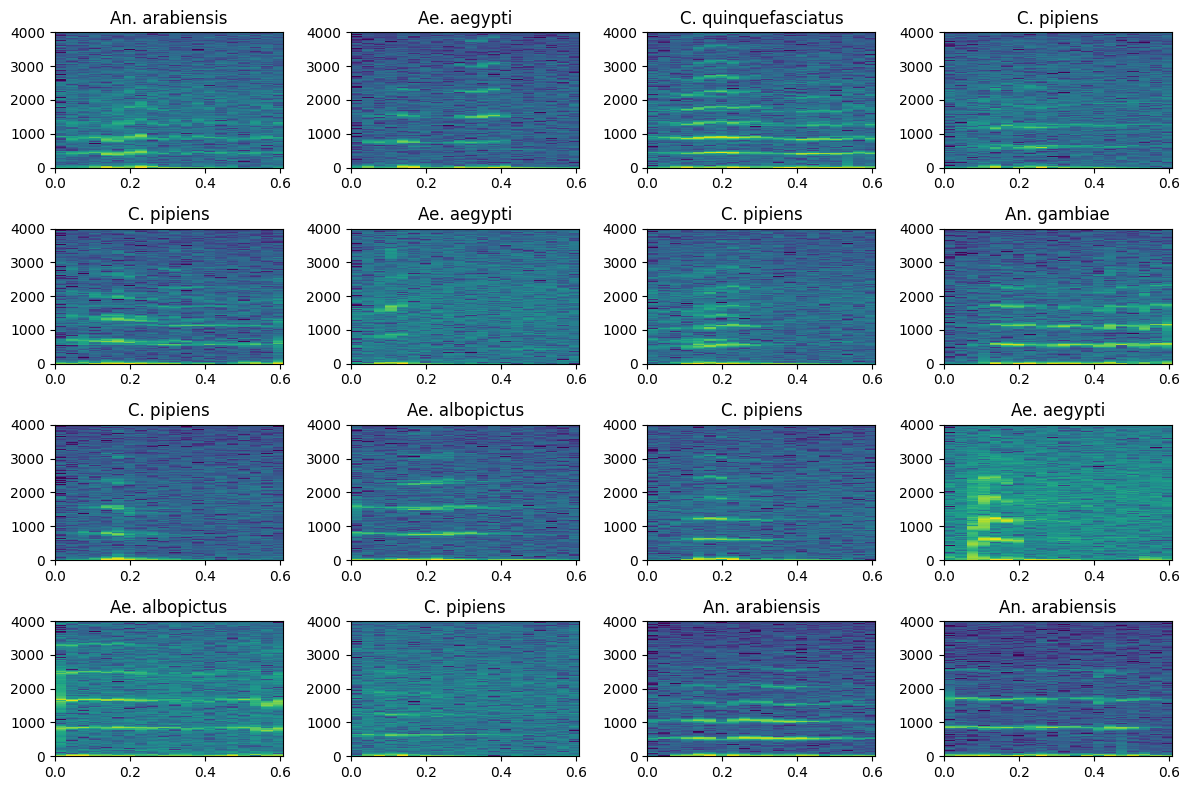

In [876]:
for data, label in train_loader:
    print(data[0].shape)
    print(label)
    spectrogram = T.Spectrogram(n_fft=512)
    spec = [spectrogram(data[i].squeeze(0)) for i in range(16)]
    #fig, axs = plt.subplots(2, 1)
    #plot_waveform(data[0], 22050, title="Original waveform", ax=axs[0])
    #plot_spectrogram(spec[0], title="spectrogram", ax=axs[1])
    #fig.tight_layout()
    # print(classes[label[0].item()])
    print(spec[0].shape)
    plot_spect(spec, label[:16])
    break

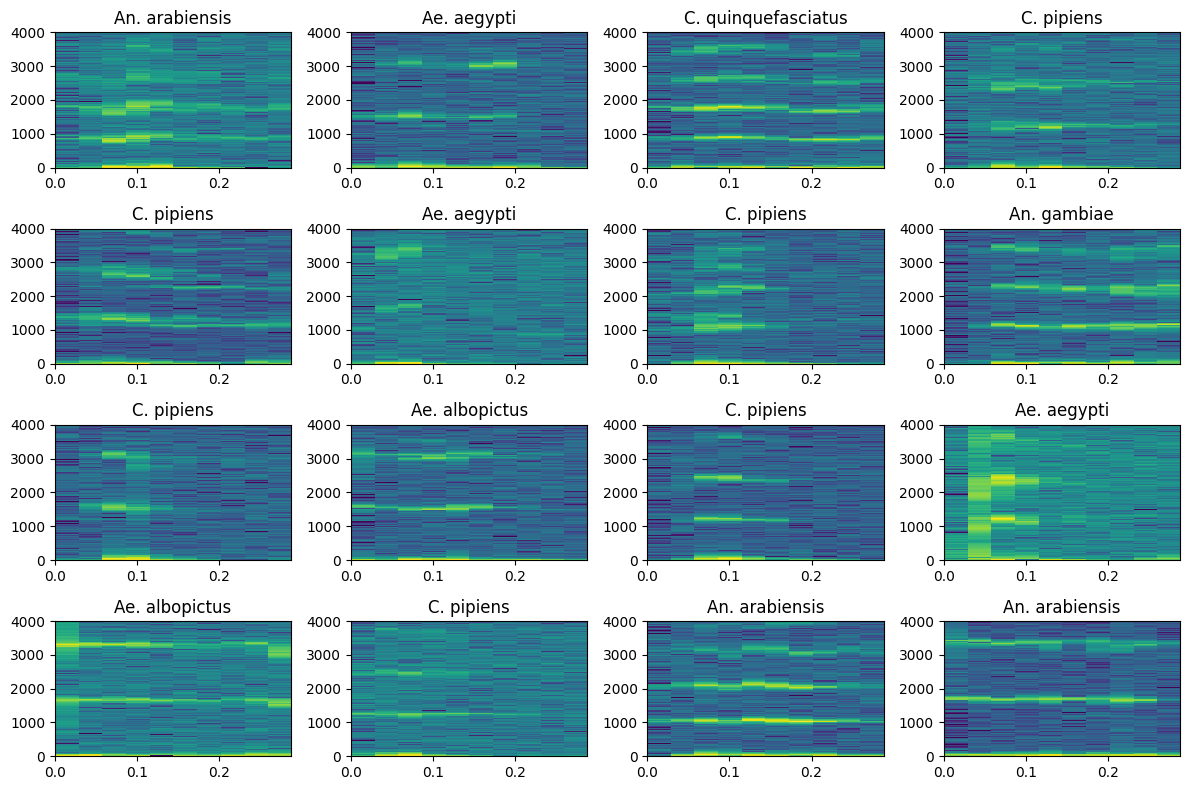

In [877]:
speech2 = torchaudio.functional.resample(data[:16], SAMPLE_RATE, SAMPLE_RATE // 2)
spec2 = [spectrogram(audio.squeeze(0)) for audio in speech2]
plot_spect(spec2, label[:16])

An. arabiensis


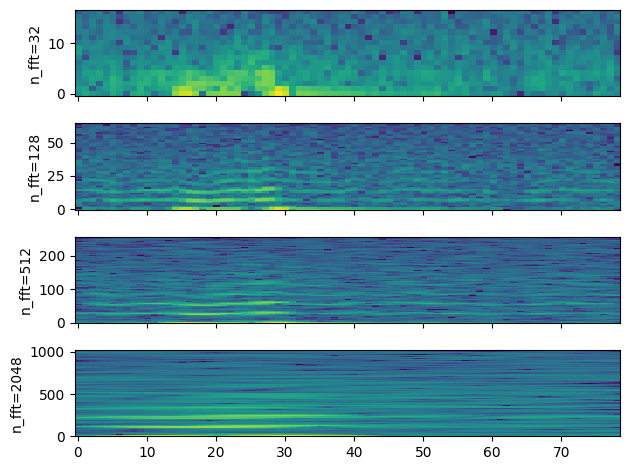

In [878]:
n_ffts = [32, 128, 512, 2048]
hop_length = 64

specs = []
for n_fft in n_ffts:
    spectrogram = T.Spectrogram(n_fft=n_fft, hop_length=hop_length)
    spec = spectrogram(data[0])
    specs.append(spec)

fig, axs = plt.subplots(len(specs), 1, sharex=True)
for i, (spec, n_fft) in enumerate(zip(specs, n_ffts)):
    plot_spectrogram(spec[0], ylabel=f"n_fft={n_fft}", ax=axs[i])
    axs[i].set_xlabel(None)
fig.tight_layout()
print(classes[label[0].item()])

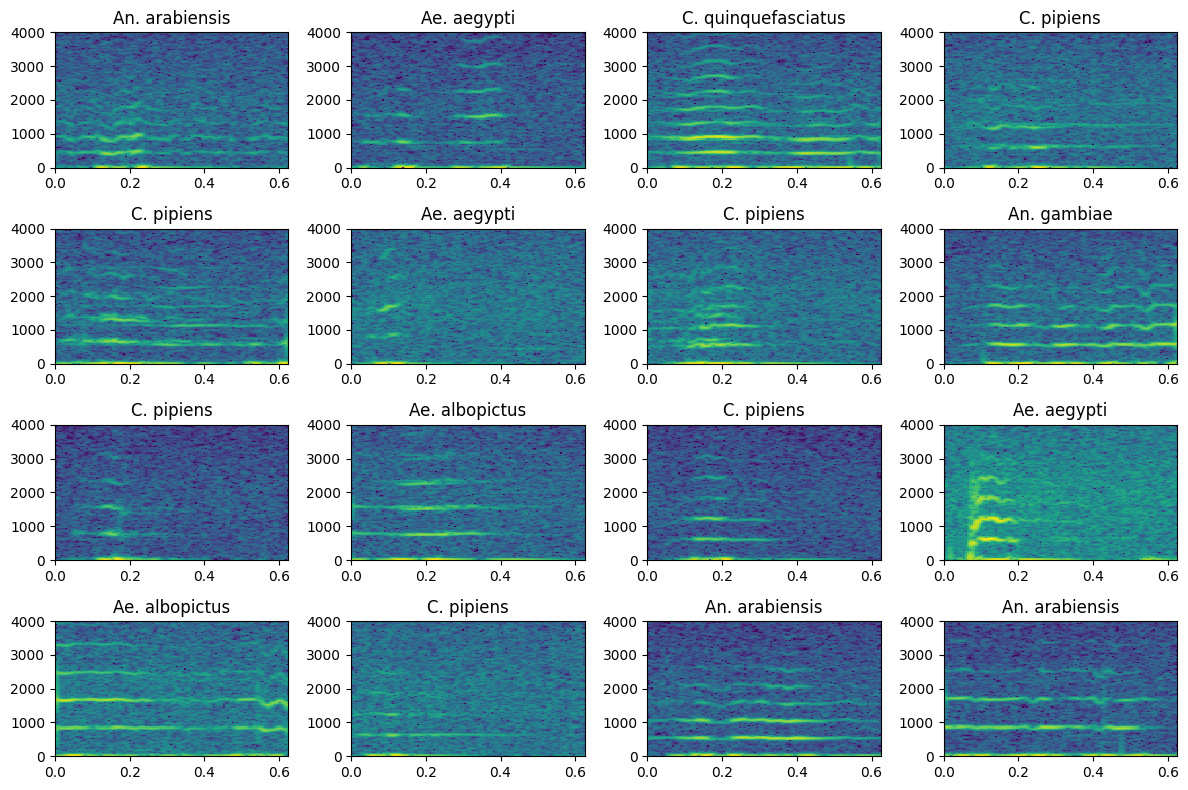

In [886]:
n_fft = 256
spectrogram = T.Spectrogram(n_fft=n_fft, hop_length=n_fft//6)
speech2 = torchaudio.functional.resample(data[:16], SAMPLE_RATE, SAMPLE_RATE // 1)
spec2 = [spectrogram(audio.squeeze(0)) for audio in speech2]
plot_spect(spec2, label[:16], hop_length=n_fft//6)

## **GriffinLim**

In [880]:
# Define transforms
n_fft = 1024
spectrogram = T.Spectrogram(n_fft=n_fft)
griffin_lim = T.GriffinLim(n_fft=n_fft)

# Apply the transforms
spec = spectrogram(data[0])
reconstructed_waveform = griffin_lim(spec)

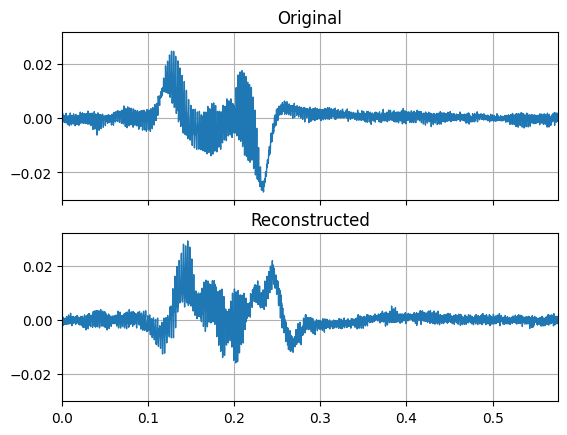

In [881]:
_, axes = plt.subplots(2, 1, sharex=True, sharey=True)
plot_waveform(data[0], SAMPLE_RATE, title="Original", ax=axes[0])
plot_waveform(reconstructed_waveform, SAMPLE_RATE, title="Reconstructed", ax=axes[1])

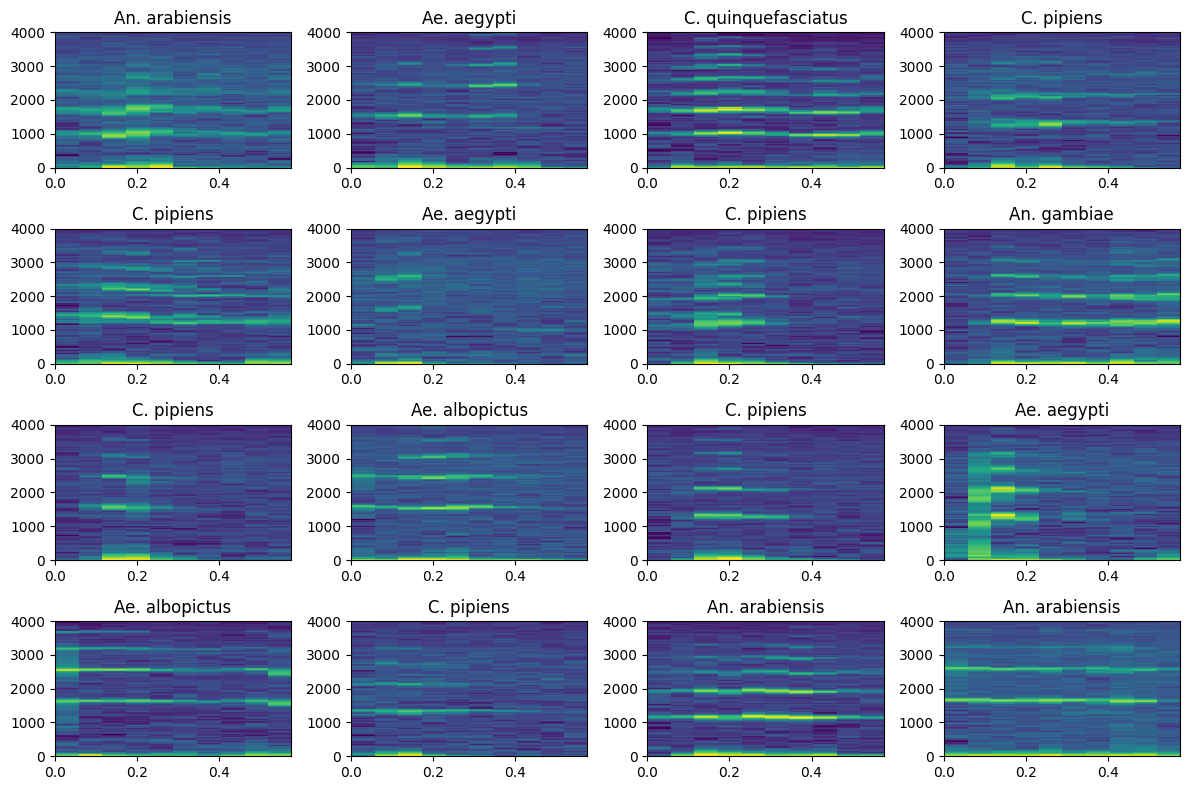

In [887]:
n_fft = 1024
win_length = None
hop_length = 512
n_mels = 128

mel_spectrogram = T.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    norm="slaney",
    n_mels=n_mels,
    mel_scale="htk",
)

spec3 = [mel_spectrogram(audio.squeeze(0)) for audio in data[:16]]

plot_spect(spec3, label[:16], hop_length)

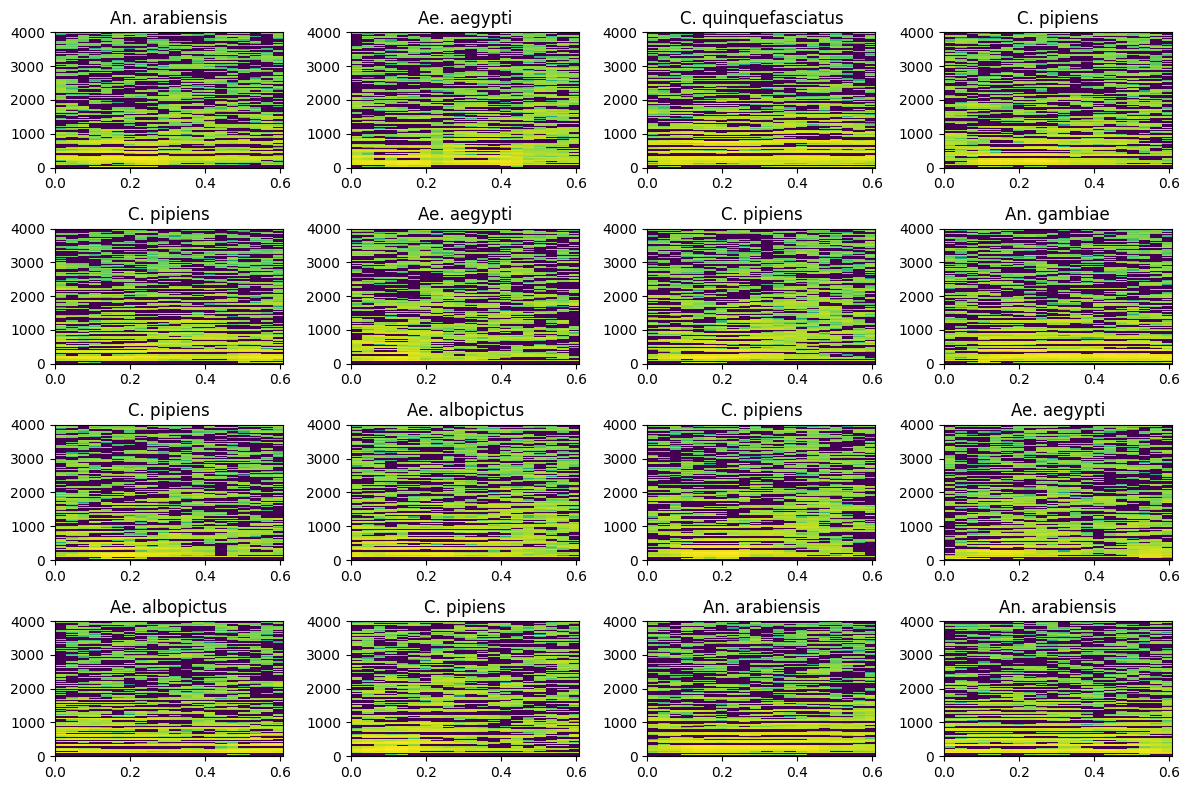

In [883]:
n_fft = 1024
win_length = None
hop_length = 256
n_mels = 128
n_mfcc = 128

mfcc_transform = T.MFCC(
    sample_rate=SAMPLE_RATE,
    n_mfcc=n_mfcc,
    melkwargs={
        "n_fft": n_fft,
        "n_mels": n_mels,
        "hop_length": hop_length,
        "mel_scale": "htk",
    },
)

spec4 = [mfcc_transform(audio.squeeze(0)) for audio in data[:16]]
plot_spect(spec4, label[:16])

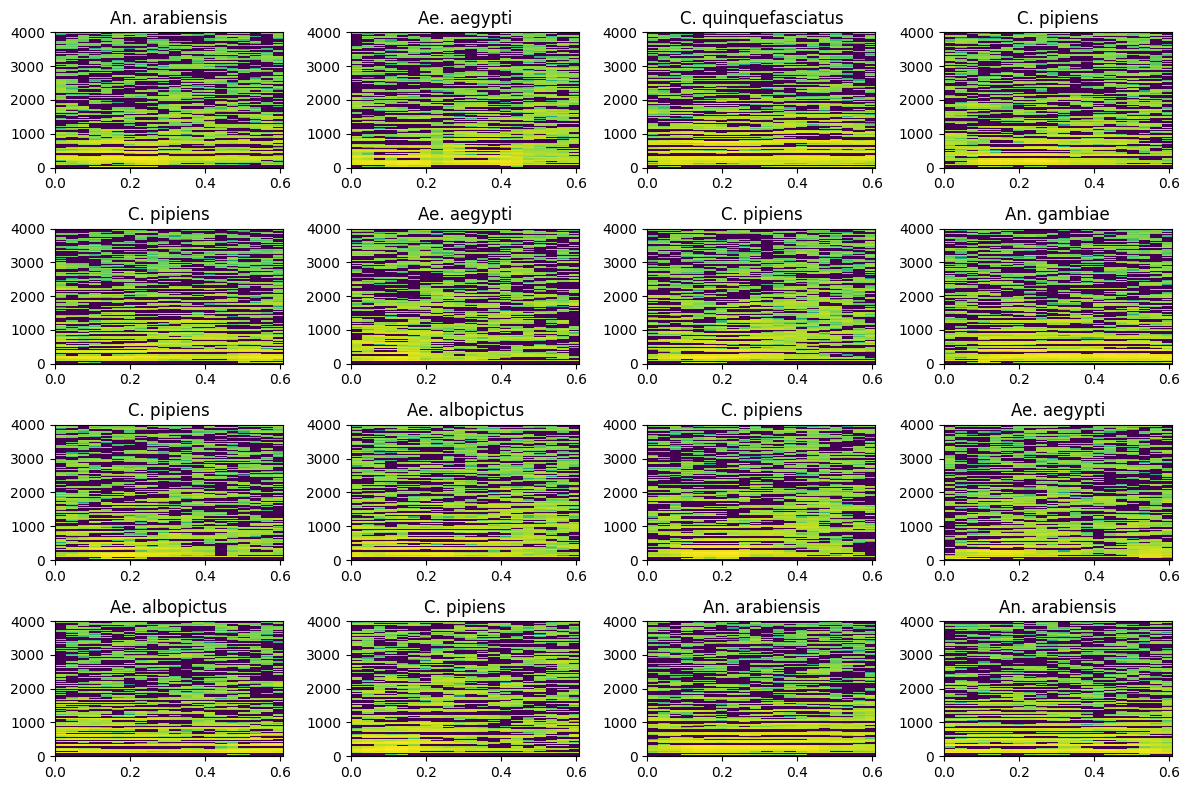

In [884]:
n_fft = 2048
win_length = None
hop_length = 512
n_lfcc = 256

lfcc_transform = T.LFCC(
    sample_rate=SAMPLE_RATE,
    n_lfcc=n_lfcc,
    speckwargs={
        "n_fft": n_fft,
        "win_length": win_length,
        "hop_length": hop_length,
    },
)

spec5 = [mfcc_transform(audio.squeeze(0)) for audio in data[:16]]
plot_spect(spec5, label[:16])